In [1]:
import spacy
import numpy as np
import pandas as pd
import os
import re
import bs4
import requests
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
from collections import Counter
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
!pip install beautifulsoup4

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [5]:
# Function to parse list-like columns
def parse_list_column(text):
    if pd.isna(text):  # Handle NaN values
        return []
    try:
        return ast.literal_eval(text)  # Parse the string representation of a list
    except (ValueError, SyntaxError):
        return []  # Return empty list if parsing fails

# Path to your CSV file
file_path = 'outfits.csv'

# Read the CSV file with semicolon separator and apply converters
try:
    candidate_sentences = pd.read_csv(file_path,
                                      sep=';',  # Semicolon as the separator
                                      quotechar='"',
                                      converters={
                                          'outfit_tags': parse_list_column,  # Parse 'outfit_tags' column
                                          'tag_categories': parse_list_column  # Parse 'tag_categories' column
                                      },
                                      on_bad_lines='skip',  # Skip bad lines to avoid parsing issues
                                      encoding='utf-8')  # Ensure correct encoding

    # Select only the 'description' column and first 3000 rows
    candidate_sentences_sys= candidate_sentences[['description']].head(3000)

    display(candidate_sentences_sys)

except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")

except Exception as e:
    print(f"An error occurred: {e}")

,description
0,"This fun, short dress features and asymmetric neckline and an eye catching metallic sheen. Concealed zipper fastening on the side."
1,"This beautiful blouse features an adjustable neckline, a short and wide silhouette, and ruching details on the sleeves. The cotton fabric makes this the perfect blouse for warmer days."
2,"Kaula from Rodebjer is a fitted dress made in mid-thigh length and sleeves in regular length. This dress is made in a vibrant seasonal print, printed on 100 % recycled polyester. Kaula is designed..."
3,"This wrap blouse has mid length sleeves and a fun, floral pattern. The cotton feels light on your skin."
4,"Feel slack and nice dressed with this pant, made in a soft cotton and linen mix that keeps you cool and comfortable."
...,...
2995,"The Saihana Floral-Print Wrap Dress from Diane von Furstenberg is a long maxi wrap dress with long sleeves, a deep v-neck and a slit along the side of the dress."
2996,The Avery Blazer from Neo Noir is simple but unique blazer with shoulder pads in the season's hottest color. The blazer comes in a soft and draped quality. The perfect statement piece that can be ...
2997,This short sleeve top has been created from an opulent jacquard fabric with a rich surface texture. The peplum design adds volume to the hem of this jacquard patterned top.
2998,"This amazing midi dress features a high split, and a see-through bodice. Pair it with your highest heels and an elegant clutch to finish the look."


In [6]:
# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Function to extract two entities from a sentence
def extract_entities(sent):
    if pd.isna(sent):
        return []  # If the sentence is NaN, return an empty list
    doc = nlp(sent)
    entities = []

    # Loop through the tokens
    for token in doc:
        # Focus on NOUNS or PROPN (Proper Nouns) for entity extraction
        if token.pos_ in ['NOUN', 'PROPN'] and not token.is_stop:
            entities.append(token.text)

    # Return only the first two entities found, or less if fewer found
    return entities[:2]

# Apply the entity extraction to all rows in the description column
candidate_sentences_sys['entities'] = candidate_sentences_sys['description'].apply(extract_entities)

# Display the DataFrame with extracted entities
print(candidate_sentences_sys[['description', 'entities']])

                                                                                                                                                                                                  description  \
0                                                                          This fun, short dress features and asymmetric neckline and an eye catching metallic sheen. Concealed zipper fastening on the side.   
1                   This beautiful blouse features an adjustable neckline, a short and wide silhouette, and ruching details on the sleeves. The cotton fabric makes this the perfect blouse for warmer days.    
2     Kaula from Rodebjer is a fitted dress made in mid-thigh length and sleeves in regular length. This dress is made in a vibrant seasonal print, printed on 100 % recycled polyester. Kaula is designed...   
3                                                                                                     This wrap blouse has mid length sleeves and a fun, floral patt

In [7]:
extract_entities("This beautiful blouse features an adjustable neckline, a short and wide silhouette, and ruching details on the sleeves. The cotton fabric makes this the perfect blouse for warmer days. ")

['blouse', 'neckline']

In [8]:
entity_pairs = []

# Use tqdm for progress tracking
for i in tqdm(candidate_sentences_sys["description"]):
    if isinstance(i, str):  # Ensure the value is a string
        entity_pairs.append(extract_entities(i))

100%|██████████| 3000/3000 [00:39<00:00, 76.03it/s]


In [9]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
entity_pairs[10:50]

[['dress', 'byTimo'],
 ['wrap', 'dress'],
 ['dress', 'V'],
 ['Blue', 'Bell'],
 ['cardigan', 'vest'],
 ['Aurora', 'necklace'],
 ['Accelerate', 'Pants'],
 ['Wave', 'Leveté'],
 ['Devy', 'Rodebjer'],
 ['coat', 'fall'],
 ['shirt', 'shape'],
 ['Dante', 'Dress'],
 ['Gucci', 'GG'],
 ['Fish', 'Jacket'],
 ['FWSS', 'Bennington'],
 ['sun', 'dress'],
 ['fun', 'jumpsuit'],
 ['jacquard', 'dress'],
 ['dress', 'fabric'],
 ['Rossby', 'Coat'],
 ['dress', 'comfort'],
 ['dress', 'Ane'],
 ['blazer', 'occasion'],
 ['Illusion', 'Skirt'],
 ['vegan', 'sleeve'],
 ['fun', 'GAP'],
 ['midi', 'wrap'],
 ['satin', 'dress'],
 ['Voss', 'Ski'],
 ['Country', 'Skirt'],
 ['Thilie', 'Maud'],
 ['satin', 'skirt'],
 ['dress', 'viscose'],
 ['dress', 'sleeves'],
 ['Flerken', 'Winter'],
 ['Peony', 'dress'],
 ['Grace', 'Bag'],
 ['Baboot', 'Sunglasses'],
 ['High', 'Pressure'],
 ['grey', 'blazer']]

In [11]:
print(f"Length of entity_pairs: {len(entity_pairs)}")
print(f"Contents of entity_pairs: {entity_pairs}")

Length of entity_pairs: 2948
Contents of entity_pairs: [['fun', 'dress'], ['blouse', 'neckline'], ['Kaula', 'Rodebjer'], ['wrap', 'blouse'], ['slack', 'pant'], ['Bumble', 'Maxi'], ['Platinum', 'Blazer'], ['Undercover', 'Sunglasses'], ['Mariposa', 'Earrings'], ['Isondo', 'Rodebjer'], ['dress', 'byTimo'], ['wrap', 'dress'], ['dress', 'V'], ['Blue', 'Bell'], ['cardigan', 'vest'], ['Aurora', 'necklace'], ['Accelerate', 'Pants'], ['Wave', 'Leveté'], ['Devy', 'Rodebjer'], ['coat', 'fall'], ['shirt', 'shape'], ['Dante', 'Dress'], ['Gucci', 'GG'], ['Fish', 'Jacket'], ['FWSS', 'Bennington'], ['sun', 'dress'], ['fun', 'jumpsuit'], ['jacquard', 'dress'], ['dress', 'fabric'], ['Rossby', 'Coat'], ['dress', 'comfort'], ['dress', 'Ane'], ['blazer', 'occasion'], ['Illusion', 'Skirt'], ['vegan', 'sleeve'], ['fun', 'GAP'], ['midi', 'wrap'], ['satin', 'dress'], ['Voss', 'Ski'], ['Country', 'Skirt'], ['Thilie', 'Maud'], ['satin', 'skirt'], ['dress', 'viscose'], ['dress', 'sleeves'], ['Flerken', 'Winter'],

In [12]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern to capture any verb followed by a noun phrase (subject)
    pattern = [
        {'DEP': 'nsubj'},  # Subject noun
        {'DEP': 'ROOT', 'POS': 'VERB'}  # Main verb
    ]

    # Add the pattern to the matcher
    matcher.add("relation_pattern", [pattern])

    matches = matcher(doc)
    if matches:  # Check if there are any matches
        # Extract the last match found
        verb_span = doc[matches[-1][1]:matches[-1][2]]

        # Return only the verb
        return verb_span[1].text  # Return just the verb

    # If no matches found, try to find any verb in the sentence
    for token in doc:
        if token.pos_ == 'VERB':
            return token.text  # Return the first verb found

    return None

In [13]:
get_relation("This wrap blouse has mid length sleeves and a fun, floral pattern. The cotton feels light on your skin.")

'feels'

In [14]:
# Ensure 'description' column is treated as strings
candidate_sentences_sys['description'] = candidate_sentences_sys['description'].astype(str)

# Apply get_relation only on non-null and non-NaN values
relations = [get_relation(i) for i in tqdm(candidate_sentences_sys['description']) if isinstance(i, str) and i != 'nan']

100%|██████████| 3000/3000 [00:42<00:00, 70.55it/s]


In [15]:
pd.Series(relations).value_counts()

,count
has,535
features,340
made,209
comes,81
makes,69
...,...
Use,1
differs,1
Feels,1
stays,1


In [16]:
print(f"Length of Relations: {len(relations)}")

Length of Relations: 2948


In [17]:
print("Relations for the first 5 rows:")
for i in range(5):
    print(f"Row {i + 1}: {relations[i]}")

Relations for the first 5 rows:
Row 1: catching
Row 2: makes
Row 3: fitted
Row 4: feels
Row 5: Feel


In [18]:
# Filter valid pairs
valid_pairs = [pair for pair in entity_pairs if len(pair) == 2]

# Extracting source and target
source = [i[0] for i in valid_pairs]
target = [i[1] for i in valid_pairs]

# Check if lengths are equal
min_length = min(len(source), len(target), len(relations))

# Truncate the lists to match the shortest one
source = source[:min_length]
target = target[:min_length]
relations = relations[:min_length]

print(f"Source length: {len(source)}, Target length: {len(target)}, Relations length: {len(relations)}\n\n")

# Creating the DataFrame with truncated lists
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
print("Truncated Knowledge Graph DataFrame:\n", kg_df)  # Display a sample of the DataFrame

# Create a directed multi-graph from the DataFrame
if not kg_df.empty:
    # Using MultiGraph allows for duplicate edges between the same nodes
    KG = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiGraph())
    print("Directed graph with duplicate edges created successfully.\n")

    print(f"Graph has {KG.number_of_nodes()} unique nodes and {KG.number_of_edges()} total edges.")

    degrees = dict(KG.degree())
    print("Degree of nodes (showing first 5):", list(degrees.items())[:5])

    for (u, v) in list(KG.edges())[:5]:  # Display first 5 edges
        print(f"Number of edges between {u} and {v}: {KG[u][v]}")

else:
    print("The DataFrame is empty. Cannot create the graph.")

Source length: 2942, Target length: 2942, Relations length: 2942


Truncated Knowledge Graph DataFrame:
        source    target      edge
0         fun     dress  catching
1      blouse  neckline     makes
2       Kaula  Rodebjer    fitted
3        wrap    blouse     feels
4       slack      pant      Feel
...       ...       ...       ...
2937  Saihana    Floral     makes
2938    Avery    Blazer       has
2939   sleeve  jacquard  features
2940    dress     split   dressed
2941    pants  material     stand

[2942 rows x 3 columns]
Directed graph with duplicate edges created successfully.

Graph has 1654 unique nodes and 2942 total edges.
Degree of nodes (showing first 5): [('fun', 17), ('dress', 457), ('blouse', 65), ('neckline', 6), ('Kaula', 2)]
Number of edges between fun and dress: {0: {'edge': 'catching'}, 1: {'edge': 'designed'}, 2: {'edge': 'has'}}
Number of edges between fun and dress: {0: {'edge': 'catching'}, 1: {'edge': 'designed'}, 2: {'edge': 'has'}}
Number of edges betwe

In [19]:
# Print results
print(f"Total number of entities: ", len(entity_pairs))
# Convert entity_pairs to a list of tuples before creating a set
print(f"Number of unique entity types: ", len(set(tuple(pair) for pair in entity_pairs)))
print(f"Total number of relations: ", len(relations))
# Convert relations to a set directly if it contains hashable elements
print(f"Number of unique relation types: ", len(set(relations)))

Total number of entities:  2948
Number of unique entity types:  1853
Total number of relations:  2942
Number of unique relation types:  368


In [20]:
print(f"Length of source: {len(source)}")
print(f"Length of target: {len(target)}")
print(f"Length of relations: {len(relations)}")

Length of source: 2942
Length of target: 2942
Length of relations: 2942


In [21]:
unique_sources = len(set(source))
unique_targets = len(set(target))
print(f"Unique sources: {unique_sources}, Unique targets: {unique_targets}")

Unique sources: 1143, Unique targets: 735


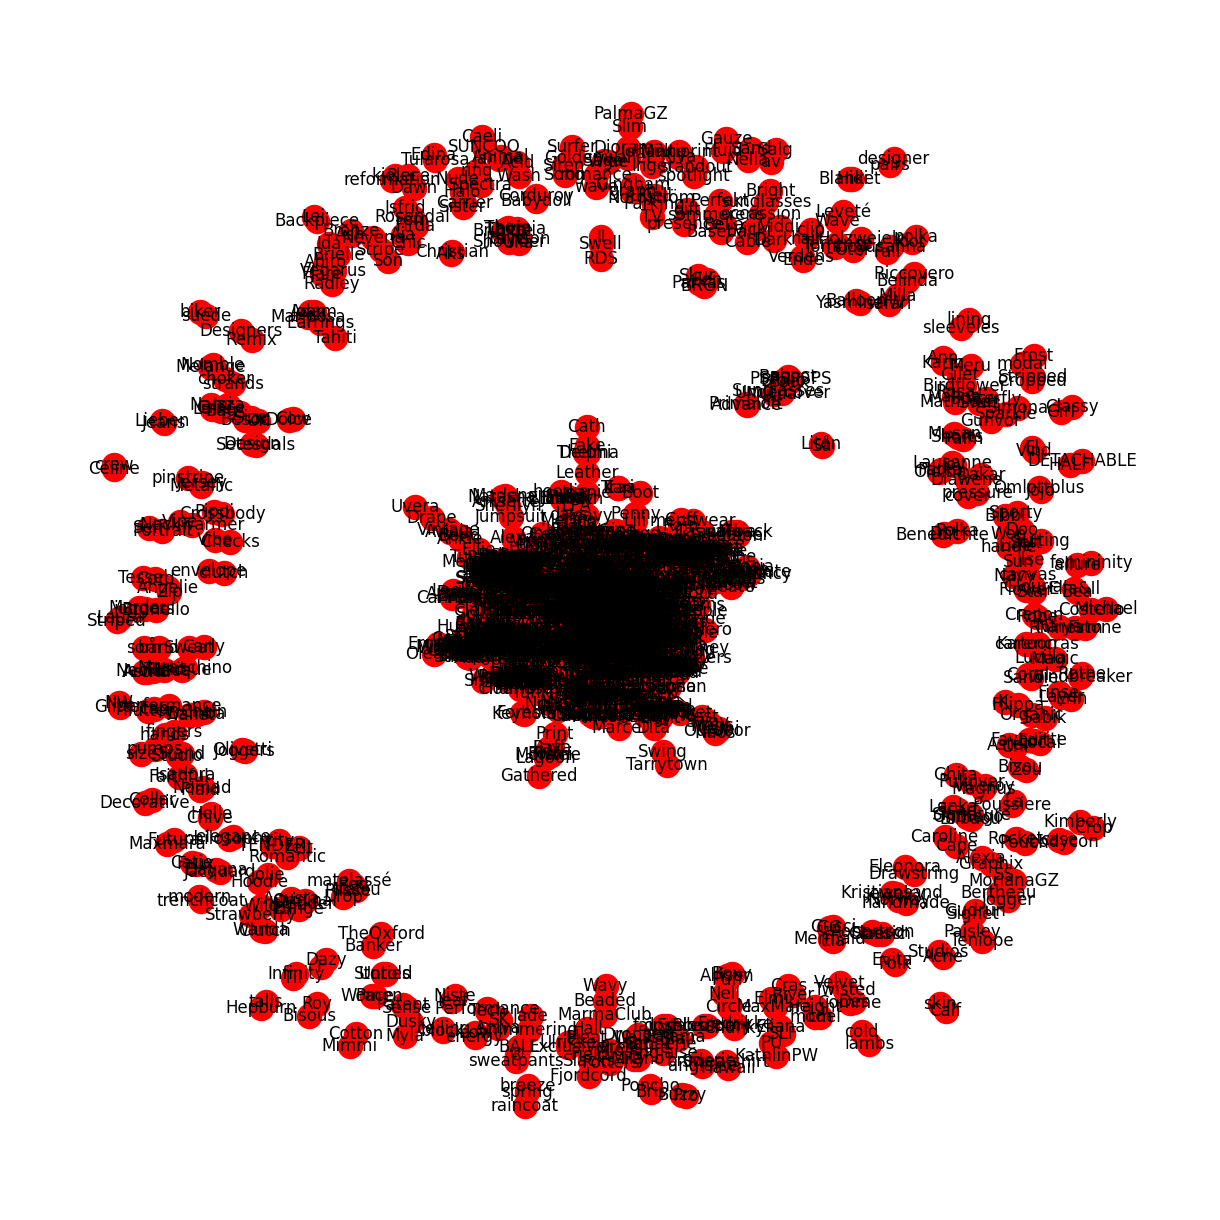

Total number of nodes in the graph: 1654
Total number of edges in the graph: 2942


In [22]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(KG)
nx.draw(KG, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()
# Print the total number of nodes in the graph
print(f"Total number of nodes in the graph: {KG.number_of_nodes()}")

# Print the total number of edges in the graph
print(f"Total number of edges in the graph: {KG.number_of_edges()}")

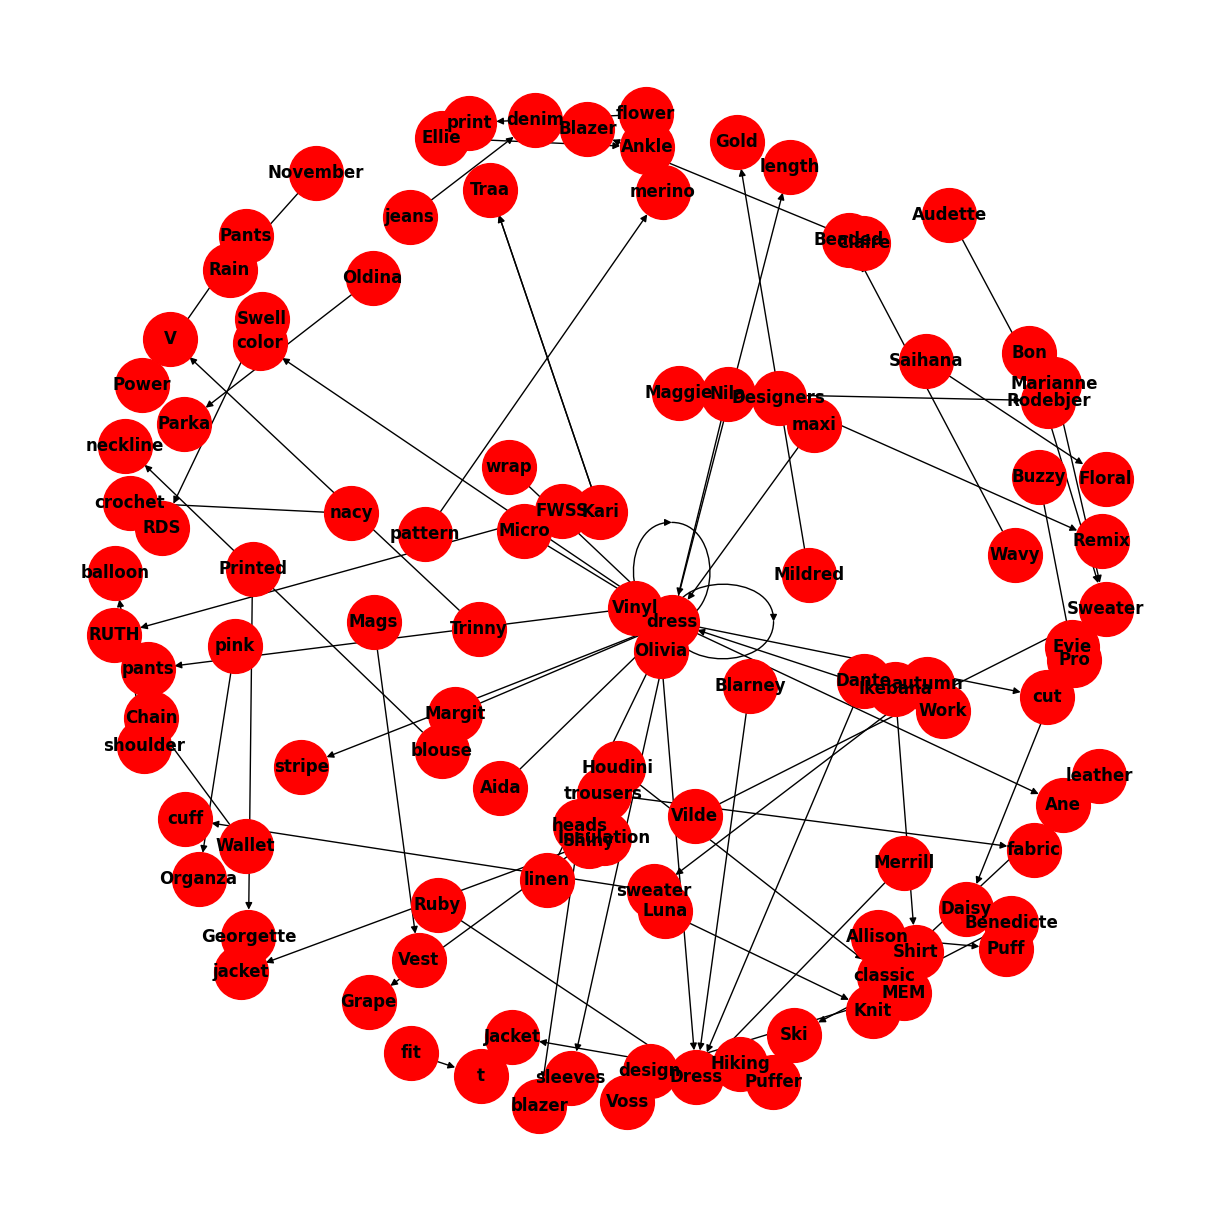

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="makes"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()

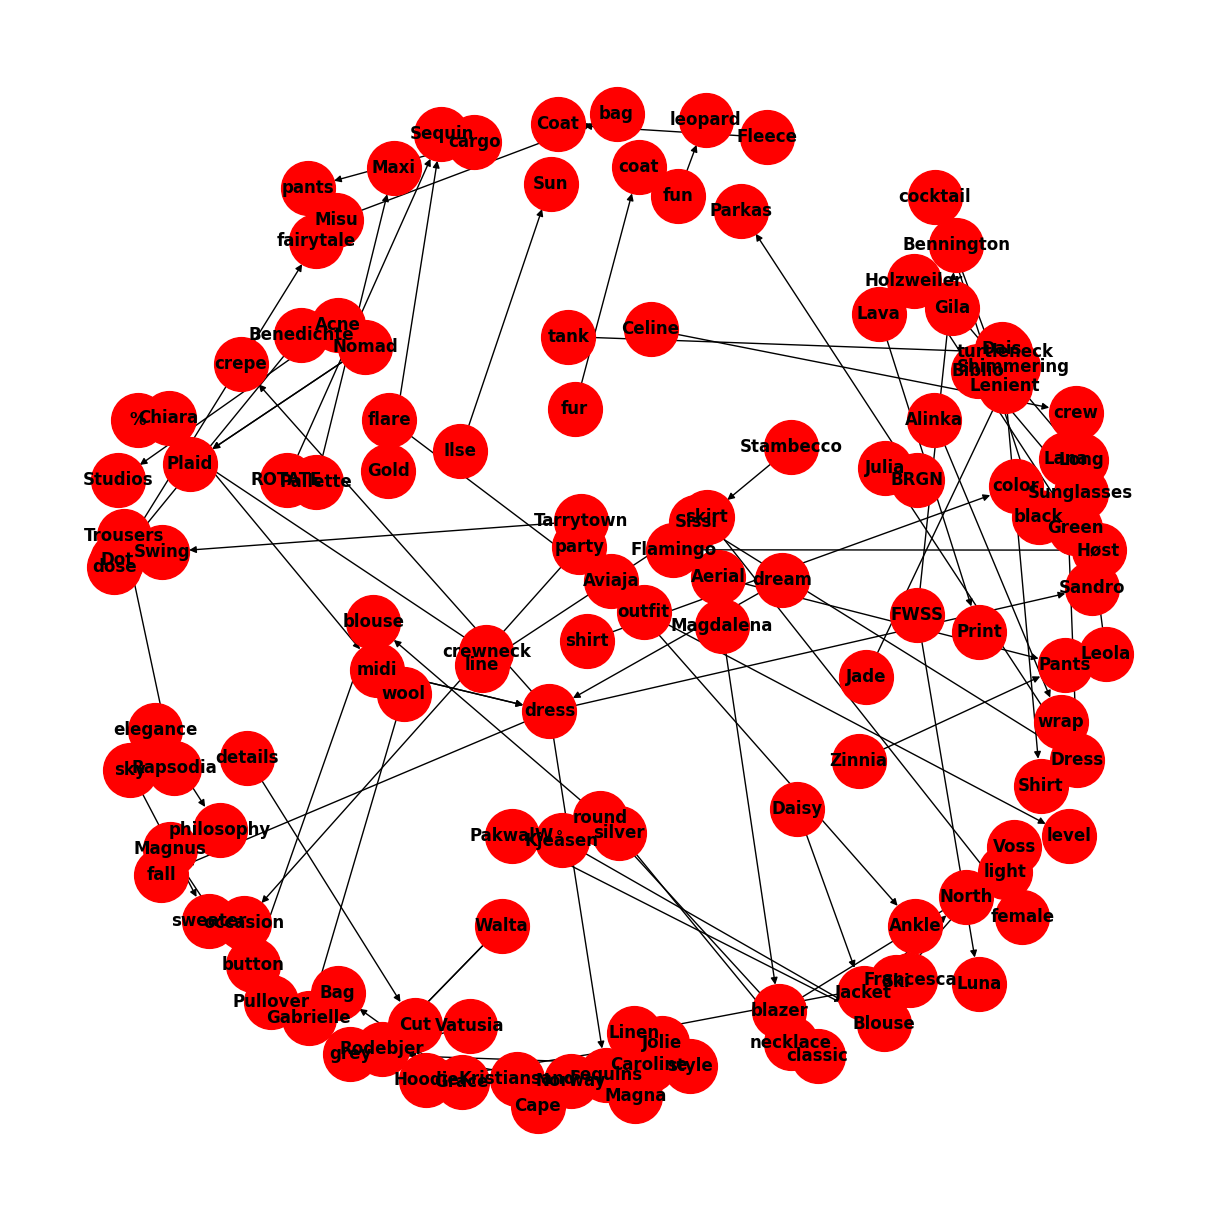

In [24]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="comes"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()

In [25]:
!pip install gravis
import gravis as gv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.1/659.1 kB 12.1 MB/s eta 0:00:00


In [26]:
# Create the NetworkX graph from the DataFrame
G = nx.from_pandas_edgelist(kg_df, "source", "target",
                             edge_attr=True, create_using=nx.MultiDiGraph())

# Assign labels to nodes based on their attributes
for node in G.nodes():
    # Assuming you want the node labels to be the same as the source and target values
    # Here we set the node label to be the node name itself (source or target)
    G.nodes[node]['label'] = node  # Or customize it further if needed

# Use gravis to visualize the graph,
vis1 = gv.vis(G,
        show_node_label=True,   # Set to True to show node labels
        show_edge_label=True,   # Set to True to show edge labels
        node_label_data_source='label',  # Use the custom label we set
        edge_label_data_source='edge')    # Use the edge attribute for labels
display(vis1)

In [27]:
# Print the total number of nodes in the graph
print(f"Total number of nodes in the graph: {G.number_of_nodes()}")

# Print the total number of edges in the graph
print(f"Total number of edges in the graph: {G.number_of_edges()}")

Total number of nodes in the graph: 1654
Total number of edges in the graph: 2942


In [28]:
explicit_added_count = 0
explicit_no_change_count = 0
implicit_added_count = 0
implicit_no_change_count = 0

# Process "SYSTEM" Data (all rows)
system_data = candidate_sentences_sys.copy()
system_data['relation'] = system_data['description'].apply(lambda x: get_relation(x) if isinstance(x, str) and x != 'nan' else None)
system_data['entities'] = system_data['description'].apply(extract_entities)

# Debugging: Print entity extraction results
print("Entities and Relations in SYSTEM data:")
print(system_data[['description', 'entities', 'relation']].head())

# Process "CHANGE" Data (rows 3001-3500)
change_data = candidate_sentences.iloc[3000:3500].copy()  # Select rows from 3001 to 3500
change_data['relation'] = change_data['description'].apply(lambda x: get_relation(x) if isinstance(x, str) and x != 'nan' else None)
change_data['entities'] = change_data['description'].apply(extract_entities)

# Debugging: Print entity extraction results
print("Entities and Relations in CHANGE data:")
print(change_data[['description', 'entities', 'relation']].head())
all_relations = set(system_data['relation'].dropna()).union(set(change_data['relation'].dropna()))
print(f"All relations:", len(all_relations))

# Create a directed MultiGraph for SYSTEM data
G_system = nx.MultiGraph()

# Create a directed MultiGraph for CHANGE data
G_change = nx.MultiGraph()

for index, row in change_data.iterrows():
    entities = row['entities']
    relation = row['relation']

    if len(entities) >= 2 and relation:
        G_change.add_edge(entities[0], entities[1], relation=relation)

# Extract explicit and implicit relations from CHANGE data
explicit_relations_change = [(u, v, G_change[u][v][0]['relation']) for u, v in G_change.edges()]
implicit_relations_change = []

for node in G_change.nodes():
    neighbors = list(G_change.neighbors(node))

    for neighbor in neighbors:
        implicit_neighbors = G_change.neighbors(neighbor)
        for implicit_neighbor in implicit_neighbors:
            if implicit_neighbor != node and not G_change.has_edge(node, implicit_neighbor):
                if G_change.has_edge(neighbor, implicit_neighbor):
                    relation = G_change[neighbor][implicit_neighbor][0]['relation']
                    implicit_relations_change.append((node, implicit_neighbor, relation))

def update_kg(KG, new_relations, added_count, no_change_count):
    for relation in new_relations:
        source, target, *rest = relation

        # Only count added or no-change edges for explicit and implicit relations
        if len(rest) > 0:
            # Check if the edge exists in the KG
            if not KG.has_edge(source, target):
                KG.add_edge(source, target, relation=rest[0])
                added_count += 1
            elif KG.has_edge(source, target) and 'relation' in KG[source][target][0] and KG[source][target][0]['relation'] != rest[0]:
                KG[source][target][0]['relation'] = rest[0]
                added_count += 1
            else:
                no_change_count += 1  # Count as no change

    return added_count, no_change_count

explicit_added_count, explicit_no_change_count = update_kg(G, explicit_relations_change, explicit_added_count, explicit_no_change_count)
implicit_added_count, implicit_no_change_count = update_kg(G, implicit_relations_change, implicit_added_count, implicit_no_change_count)

# Print results for the updated knowledge graph KGu
print(f"Total Nodes in KGu: {G.number_of_nodes()}")
print(f"Total Relations in KGu: {G.number_of_edges()}")

print(f"Total Explicit Relations: {len(explicit_relations_change)}")
print(f"Total Implicit Relations: {len(implicit_relations_change)}\n")

print(f"Total Explicit Added Edges: {explicit_added_count}")
print(f"Total Explicit No Change Edges: {explicit_no_change_count}")
print(f"Total Implicit Added Edges: {implicit_added_count}")
print(f"Total Implicit No Change Edges: {implicit_no_change_count}\n\n")
print(f"Total ADD: {explicit_added_count + implicit_added_count}")
print(f"Total NO CHANGE: {explicit_no_change_count + implicit_no_change_count}")

Entities and Relations in SYSTEM data:
                                                                                                                                                                                               description  \
0                                                                       This fun, short dress features and asymmetric neckline and an eye catching metallic sheen. Concealed zipper fastening on the side.   
1                This beautiful blouse features an adjustable neckline, a short and wide silhouette, and ruching details on the sleeves. The cotton fabric makes this the perfect blouse for warmer days.    
2  Kaula from Rodebjer is a fitted dress made in mid-thigh length and sleeves in regular length. This dress is made in a vibrant seasonal print, printed on 100 % recycled polyester. Kaula is designed...   
3                                                                                                  This wrap blouse has mid length sleeve

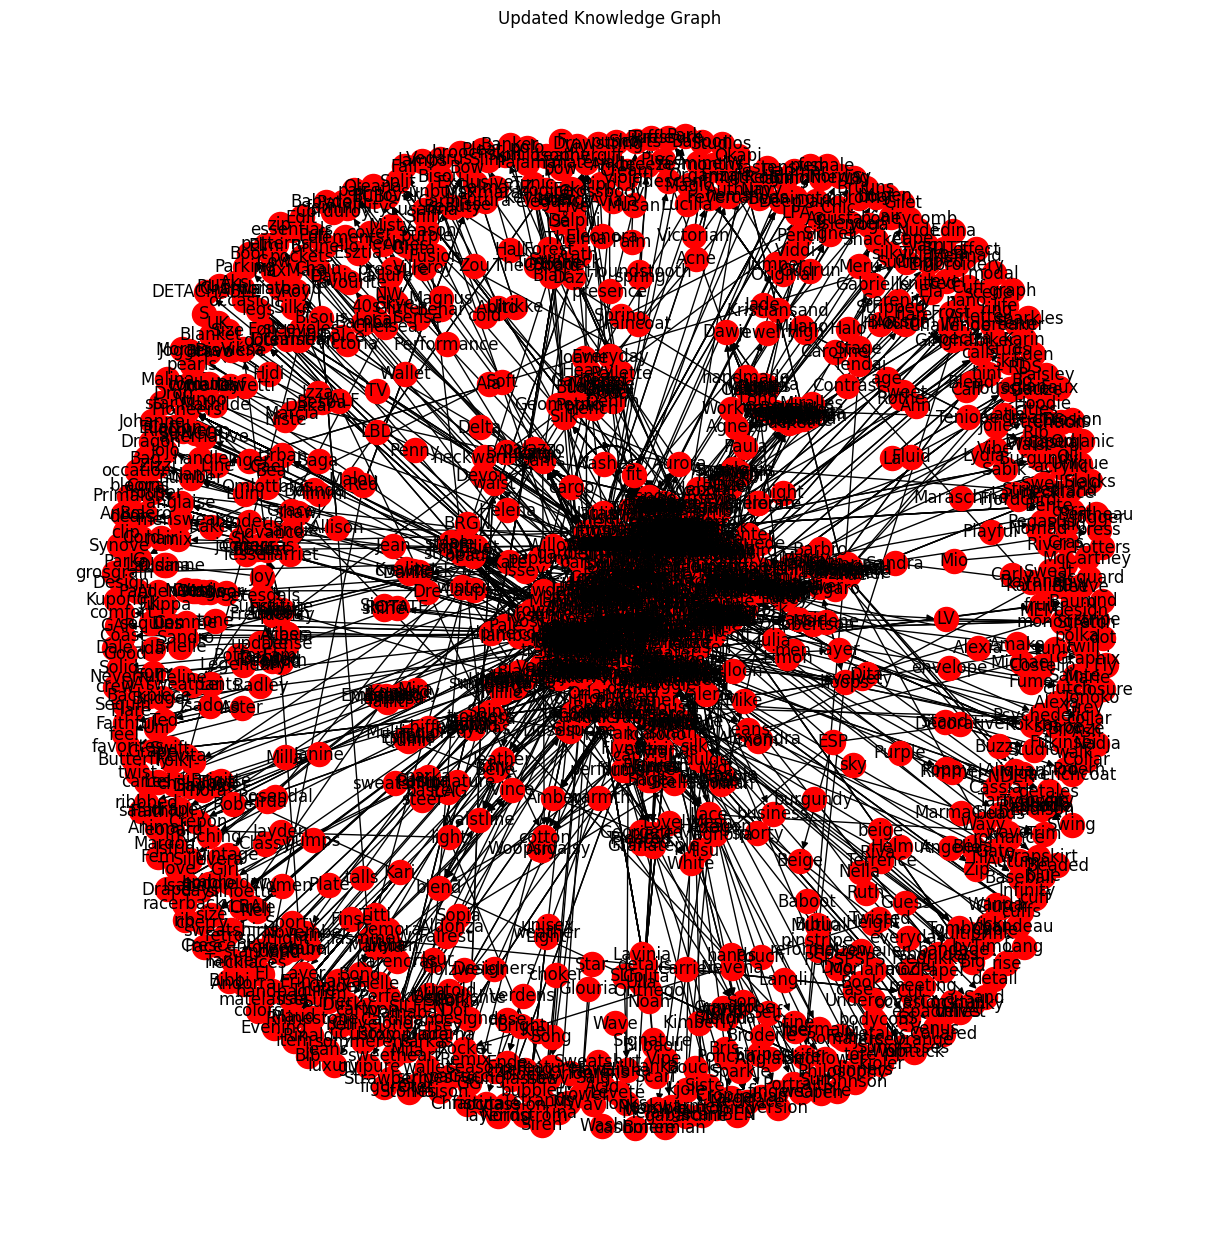

Total number of nodes in the graph: 1807
Total number of edges in the graph: 7440


In [29]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.title('Updated Knowledge Graph')
plt.show()
# Print the total number of nodes in the graph
print(f"Total number of nodes in the graph: {G.number_of_nodes()}")

# Print the total number of edges in the graph
print(f"Total number of edges in the graph: {G.number_of_edges()}")

In [41]:
csv_file_path = "/content/relations_with_labels.csv"
kg_df = pd.read_csv(csv_file_path)
explicit_data = kg_df[kg_df['type'] == 'Explicit']
implicit_data = kg_df[kg_df['type'] == 'Implicit']
explicit_graph = nx.from_pandas_edgelist(explicit_data, source="source", target="target", edge_attr=True, create_using=nx.MultiGraph())
implicit_graph = nx.from_pandas_edgelist(implicit_data, source="source", target="target", edge_attr=True, create_using=nx.MultiGraph())

In [ ]:
start_time = time.time()

# RotatE Model Implementation
class RotatE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(RotatE, self).__init__()
        self.entity_embedding = nn.Parameter(torch.randn(num_entities, embedding_dim))
        self.relation_embedding = nn.Parameter(torch.randn(num_relations, embedding_dim))

    def forward(self, head, relation, tail):
        # Apply the RotatE model: head * relation
        head_emb = self.entity_embedding[head]
        relation_emb = self.relation_embedding[relation]
        tail_emb = self.entity_embedding[tail]

        # Rotate head embeddings by relation embeddings
        rotated_head = head_emb * relation_emb

        # Calculate similarity (distance metric)
        distance = torch.norm(rotated_head - tail_emb, p=2)
        return distance

# Function to train the RotatE model
def train_rotate(KG, num_epochs=100, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for (head, tail, relation) in KG.edges(data='relation'):
            optimizer.zero_grad()
            # Assume head, tail, relation are indexed properly
            head_idx = entity_to_idx[head]
            tail_idx = entity_to_idx[tail]
            relation_idx = relation_to_idx[relation]

            # Forward pass
            loss = model(head_idx, relation_idx, tail_idx)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss}')

# Function to evaluate accuracy
def evaluate_accuracy(KG, threshold):
    correct_predictions = 0
    total_predictions = 0
    for (head, tail, relation) in KG.edges(data='relation'):
        head_idx = entity_to_idx.get(head)
        tail_idx = entity_to_idx.get(tail)
        relation_idx = relation_to_idx.get(relation)

        # Ensure relation_idx is found
        if relation_idx is None:
            print(f"Relation '{relation}' not found in relation_to_idx.")
            continue  # Skip this relation if it doesn't exist

        predicted_distance = model(head_idx, relation_idx, tail_idx)
        if predicted_distance.item() < threshold:  # Set an appropriate threshold
            correct_predictions += 1
        total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

# Create index mappings for entities and relations
entity_to_idx = {entity: idx for idx, entity in enumerate(G.nodes())}

# Extract unique relations from the edges of the KG
unique_relations = set(relation for _, _, relation in G.edges(data='relation'))
relation_to_idx = {relation: idx for idx, relation in enumerate(unique_relations)}

# Initialize RotatE model
embedding_dim = 100  # Set the dimension of the embeddings
model = RotatE(num_entities=len(entity_to_idx), num_relations=len(relation_to_idx), embedding_dim=embedding_dim)

threshold = 0.3
accuracies = []

# Train the model (already defined in the previous code)
train_rotate(G)

# Evaluate accuracy for each threshold
accuracy = evaluate_accuracy(G, threshold)
accuracies.append(accuracy)

# Calculate and print the time taken
end_time = time.time()
print(f"Total Execution Time: {end_time - start_time:.2f} seconds for Updated Knowledge Graph")

In [42]:
start_time = time.time()

# RotatE Model Implementation
class RotatE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(RotatE, self).__init__()
        self.entity_embedding = nn.Parameter(torch.randn(num_entities, embedding_dim))
        self.relation_embedding = nn.Parameter(torch.randn(num_relations, embedding_dim))

    def forward(self, head, relation, tail):
        # Apply the RotatE model: head * relation
        head_emb = self.entity_embedding[head]
        relation_emb = self.relation_embedding[relation]
        tail_emb = self.entity_embedding[tail]

        # Rotate head embeddings by relation embeddings
        rotated_head = head_emb * relation_emb

        # Calculate similarity (distance metric)
        # Ensure the shapes are correct for distance calculation
        distance = torch.norm(rotated_head - tail_emb, p=2)
        return distance

# Function to train the RotatE model
def train_rotate(KG, num_epochs=100, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for (head, tail, relation) in KG.edges(data='relation'):
            optimizer.zero_grad()
            # Assume head, tail, relation are indexed properly
            head_idx = entity_to_idx[head]
            tail_idx = entity_to_idx[tail]
            relation_idx = relation_to_idx[relation]

            # Forward pass
            loss = model(head_idx, relation_idx, tail_idx)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss}')

# Function to evaluate accuracy
def evaluate_accuracy(KG, threshold):
    correct_predictions = 0
    total_predictions = 0
    for (head, tail, relation) in KG.edges(data='relation'):
        head_idx = entity_to_idx.get(head)
        tail_idx = entity_to_idx.get(tail)
        relation_idx = relation_to_idx.get(relation)

        # Ensure relation_idx is found
        if relation_idx is None:
            print(f"Relation '{relation}' not found in relation_to_idx.")
            continue  # Skip this relation if it doesn't exist

        predicted_distance = model(head_idx, relation_idx, tail_idx)
        if predicted_distance.item() < threshold:  # Set an appropriate threshold
            correct_predictions += 1
        total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

# Create index mappings for entities and relations
entity_to_idx = {entity: idx for idx, entity in enumerate(implicit_graph.nodes())}

# Extract unique relations from the edges of the KG
unique_relations = set(relation for _, _, relation in implicit_graph.edges(data='relation'))
relation_to_idx = {relation: idx for idx, relation in enumerate(unique_relations)}

# Initialize RotatE model
embedding_dim = 100  # Set the dimension of the embeddings
model = RotatE(num_entities=len(entity_to_idx), num_relations=len(relation_to_idx), embedding_dim=embedding_dim)

threshold = 0.3

# Train the model (already defined in the previous code)
train_rotate(implicit_graph)

accuracy = evaluate_accuracy(implicit_graph, threshold)

print(f'Accuracy for threshold {threshold}: {accuracy * 100:.2f}%')

end_time = time.time()
print(f"Total Execution Time: {end_time - start_time:.2f} seconds for Implicit relations")

Epoch 1/100, Loss: 49762.912023067474
Epoch 2/100, Loss: 37026.772156238556
Epoch 3/100, Loss: 29303.30369758606
Epoch 4/100, Loss: 24292.410107567906
Epoch 5/100, Loss: 20690.24190957658
Epoch 6/100, Loss: 17870.676507103257
Epoch 7/100, Loss: 15542.014534416609
Epoch 8/100, Loss: 13603.566910292022
Epoch 9/100, Loss: 11969.75951786898
Epoch 10/100, Loss: 10582.331989817321
Epoch 11/100, Loss: 9407.302087081596
Epoch 12/100, Loss: 8414.813961577136
Epoch 13/100, Loss: 7578.73233684618
Epoch 14/100, Loss: 6871.150064992718
Epoch 15/100, Loss: 6265.931364104152
Epoch 16/100, Loss: 5737.245417184662
Epoch 17/100, Loss: 5266.656768050976
Epoch 18/100, Loss: 4845.365295076044
Epoch 19/100, Loss: 4471.6017357320525
Epoch 20/100, Loss: 4133.664691335522
Epoch 21/100, Loss: 3826.9768379549496
Epoch 22/100, Loss: 3548.2648832800332
Epoch 23/100, Loss: 3294.2438175417483
Epoch 24/100, Loss: 3063.27799283294
Epoch 25/100, Loss: 2851.581104707904
Epoch 26/100, Loss: 2655.5803645337
Epoch 27/100, 

In [44]:
start_time = time.time()

# RotatE Model Implementation
class RotatE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(RotatE, self).__init__()
        self.entity_embedding = nn.Parameter(torch.randn(num_entities, embedding_dim))
        self.relation_embedding = nn.Parameter(torch.randn(num_relations, embedding_dim))

    def forward(self, head, relation, tail):
        # Apply the RotatE model: head * relation
        head_emb = self.entity_embedding[head]
        relation_emb = self.relation_embedding[relation]
        tail_emb = self.entity_embedding[tail]

        # Rotate head embeddings by relation embeddings
        rotated_head = head_emb * relation_emb

        # Calculate similarity (distance metric)
        # Ensure the shapes are correct for distance calculation
        distance = torch.norm(rotated_head - tail_emb, p=2)
        return distance

# Function to train the RotatE model
def train_rotate(KG, num_epochs=100, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for (head, tail, relation) in KG.edges(data='relation'):
            optimizer.zero_grad()
            # Assume head, tail, relation are indexed properly
            head_idx = entity_to_idx[head]
            tail_idx = entity_to_idx[tail]
            relation_idx = relation_to_idx[relation]

            # Forward pass
            loss = model(head_idx, relation_idx, tail_idx)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss}')

# Function to evaluate accuracy
def evaluate_accuracy(KG, threshold):
    correct_predictions = 0
    total_predictions = 0
    for (head, tail, relation) in KG.edges(data='relation'):
        head_idx = entity_to_idx.get(head)
        tail_idx = entity_to_idx.get(tail)
        relation_idx = relation_to_idx.get(relation)

        # Ensure relation_idx is found
        if relation_idx is None:
            print(f"Relation '{relation}' not found in relation_to_idx.")
            continue  # Skip this relation if it doesn't exist

        predicted_distance = model(head_idx, relation_idx, tail_idx)
        if predicted_distance.item() < threshold:  # Set an appropriate threshold
            correct_predictions += 1
        total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

# Create index mappings for entities and relations
entity_to_idx = {entity: idx for idx, entity in enumerate(explicit_graph.nodes())}

# Extract unique relations from the edges of the KG
unique_relations = set(relation for _, _, relation in explicit_graph.edges(data='relation'))
relation_to_idx = {relation: idx for idx, relation in enumerate(unique_relations)}

# Initialize RotatE model
embedding_dim = 100  # Set the dimension of the embeddings
model = RotatE(num_entities=len(entity_to_idx), num_relations=len(relation_to_idx), embedding_dim=embedding_dim)

threshold = 0.3

# Train the model (already defined in the previous code)
train_rotate(explicit_graph)

accuracy = evaluate_accuracy(explicit_graph, threshold)

print(f'Accuracy for threshold {threshold}: {accuracy * 100:.2f}%')

end_time = time.time()
print(f"Total Execution Time: {end_time - start_time:.2f} seconds for Explicit relations")

Epoch 1/100, Loss: 6363.197974205017
Epoch 2/100, Loss: 5667.0758600234985
Epoch 3/100, Loss: 5121.721717834473
Epoch 4/100, Loss: 4703.015706062317
Epoch 5/100, Loss: 4373.182414054871
Epoch 6/100, Loss: 4104.206179618835
Epoch 7/100, Loss: 3877.1500124931335
Epoch 8/100, Loss: 3679.4400792121887
Epoch 9/100, Loss: 3502.72314953804
Epoch 10/100, Loss: 3341.5448648929596
Epoch 11/100, Loss: 3192.3453031778336
Epoch 12/100, Loss: 3052.731631398201
Epoch 13/100, Loss: 2920.904515862465
Epoch 14/100, Loss: 2795.5301172733307
Epoch 15/100, Loss: 2675.7589072287083
Epoch 16/100, Loss: 2561.367829605937
Epoch 17/100, Loss: 2453.2193871065974
Epoch 18/100, Loss: 2352.677688796073
Epoch 19/100, Loss: 2256.726952791214
Epoch 20/100, Loss: 2165.0093491896987
Epoch 21/100, Loss: 2081.9493540432304
Epoch 22/100, Loss: 2003.4148049075156
Epoch 23/100, Loss: 1930.896694675088
Epoch 24/100, Loss: 1859.7010552119464
Epoch 25/100, Loss: 1793.2442789115012
Epoch 26/100, Loss: 1726.8247717665508
Epoch 27

In [45]:
start_time = time.time()

# Function to parse list-like columns safely
def parse_list_column(text):
    if pd.isna(text):  # Handle NaN values
        return []
    try:
        return ast.literal_eval(text)  # Parse the string representation of a list
    except (ValueError, SyntaxError):
        return []  # Return empty list if parsing fails

data = pd.read_csv('change_data_tuples.csv')
data['label'] = np.random.randint(0, 2, size=463)

# Extract relevant columns
heads = data['source'].values
relations = data['relation'].values
tails = data['target'].values
labels = data['label'].values

# Encode entities and relations
entity_set = set(heads).union(set(tails))
relation_set = set(relations)

entity_to_id = {entity: idx for idx, entity in enumerate(entity_set)}
relation_to_id = {relation: idx for idx, relation in enumerate(relation_set)}

# Map entities and relations to IDs
head_ids = np.array([entity_to_id[h] for h in heads])
relation_ids = np.array([relation_to_id[r] for r in relations])
tail_ids = np.array([entity_to_id[t] for t in tails])

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    list(zip(head_ids, relation_ids, tail_ids)), labels, test_size=0.18, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to tensors
def prepare_tensors(data):
    heads, relations, tails = zip(*data)
    return torch.tensor(heads, dtype=torch.long), torch.tensor(relations, dtype=torch.long), torch.tensor(tails, dtype=torch.long)

X_train_heads, X_train_relations, X_train_tails = prepare_tensors(X_train)
X_val_heads, X_val_relations, X_val_tails = prepare_tensors(X_val)
X_test_heads, X_test_relations, X_test_tails = prepare_tensors(X_test)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Define the RotatH model
class RotatH(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(RotatH, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 1)  # Fully connected layer to output a single value

    def forward(self, head, relation, tail):
        head_emb = self.entity_embeddings(head)
        relation_emb = self.relation_embeddings(relation)
        tail_emb = self.entity_embeddings(tail)

        # Rotation in complex space (example)
        head_rotated = head_emb * torch.cos(relation_emb) + head_emb * torch.sin(relation_emb)

        # Compute similarity score (example approach)
        similarity = head_rotated * tail_emb

        # Output a single value (logit) for binary classification
        return self.fc(similarity).squeeze(1)  # Use .squeeze(1) to reduce dimensionality

# Initialize model parameters
num_entities = len(entity_to_id)
num_relations = len(relation_to_id)
embedding_dim = 100  # Adjust based on your requirement
model = RotatH(num_entities, num_relations, embedding_dim)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    logits = model(X_train_heads, X_train_relations, X_train_tails)

    # Compute loss
    loss = criterion(logits, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Validation phase
model.eval()
with torch.no_grad():
    val_logits = model(X_val_heads, X_val_relations, X_val_tails)
    val_predictions = torch.sigmoid(val_logits)
    val_pred_labels = (val_predictions > 0.5).float()
    accuracy = (val_pred_labels == y_val_tensor).float().mean()
    print(f'Validation Accuracy: {accuracy.item() * 100:.2f}%')

# Test phase
with torch.no_grad():
    test_logits = model(X_test_heads, X_test_relations, X_test_tails)
    test_predictions = torch.sigmoid(test_logits)
    test_pred_labels = (test_predictions > 0.5).float()
    test_accuracy = (test_pred_labels == torch.tensor(y_test, dtype=torch.float32)).float().mean()
    print(f'Test Accuracy: {test_accuracy.item() * 100:.2f}%')

# Calculate and print the time taken
end_time = time.time()
print(f"Total Execution Time: {end_time - start_time:.2f} seconds")

Epoch [1/100], Loss: 0.7237
Epoch [2/100], Loss: 0.7183
Epoch [3/100], Loss: 0.7129
Epoch [4/100], Loss: 0.7076
Epoch [5/100], Loss: 0.7025
Epoch [6/100], Loss: 0.6974
Epoch [7/100], Loss: 0.6924
Epoch [8/100], Loss: 0.6875
Epoch [9/100], Loss: 0.6827
Epoch [10/100], Loss: 0.6779
Epoch [11/100], Loss: 0.6732
Epoch [12/100], Loss: 0.6687
Epoch [13/100], Loss: 0.6641
Epoch [14/100], Loss: 0.6597
Epoch [15/100], Loss: 0.6553
Epoch [16/100], Loss: 0.6509
Epoch [17/100], Loss: 0.6466
Epoch [18/100], Loss: 0.6423
Epoch [19/100], Loss: 0.6381
Epoch [20/100], Loss: 0.6339
Epoch [21/100], Loss: 0.6297
Epoch [22/100], Loss: 0.6256
Epoch [23/100], Loss: 0.6214
Epoch [24/100], Loss: 0.6173
Epoch [25/100], Loss: 0.6132
Epoch [26/100], Loss: 0.6091
Epoch [27/100], Loss: 0.6050
Epoch [28/100], Loss: 0.6009
Epoch [29/100], Loss: 0.5968
Epoch [30/100], Loss: 0.5927
Epoch [31/100], Loss: 0.5885
Epoch [32/100], Loss: 0.5844
Epoch [33/100], Loss: 0.5802
Epoch [34/100], Loss: 0.5761
Epoch [35/100], Loss: 0

In [46]:
# Install Git and set up your details
!git config --global user.name "JashwanthL7"
!git config --global user.email "kandulajashwanth@example.com"

# Clone your GitHub repository
!git clone https://github.com/JashwanthK7/RotatE

# Copy your notebook to the repository folder
!cp Team2.ipynb RotatE/

# Navigate to the repository folder
%cd RotatE

# Add, commit, and push your changes
!git add .
!git commit -m "Added my Colab notebook"
!git push

Cloning into 'RotatE'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
cp: cannot stat 'Team2.ipynb': No such file or directory
/content/RotatE
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
